# Classifier Method Comparison

Compare two classification methods on the same BYOL embeddings:
- **K-NN Label Propagation**: Iterative K-NN based classification using PCA-reduced embeddings
- **Neural Network Classifier**: Trained classifier head on raw BYOL embeddings

This notebook:
1. Loads embeddings from a single experiment (current config)
2. Applies two different classification methods to the same data
3. Generates probabilistic labels from both classifiers
4. Compares classification performance and label distributions
5. Visualizes differences in merger classification between methods

**Use cases:**
- Compare K-NN vs neural network classification performance
- Evaluate which method produces more reliable probabilistic labels
- Understand systematic differences between classification approaches
- Identify cases where classifiers disagree

## Setup and Imports

In [1]:
import os
os.chdir('/Users/kadofong/work/projects/merian/pieridae/merger_analysis/notebooks')

In [2]:
%load_ext autoreload
%autoreload 2

import sys
from pathlib import Path

# Add pieridae to path
sys.path.insert(0, str(Path.cwd().parents[1]))

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import yaml
import pickle
import logging
from typing import Dict, Tuple

from pieridae.starbursts.byol import (
    EmbeddingAnalyzer,
    LabelPropagation,
    compute_classification_metrics
)

# Import make_punchlines module
sys.path.insert(0, str(Path.cwd().parent / 'figure_generation'))
import make_punchlines

# Plotting utilities
from ekfplot import plot as ek, colors as ec, colorlists

/Users/kadofong/opt/miniconda3/envs/merian/lib/python3.10/site-packages/umap/__init__.py:9: ImportWarning: Tensorflow not installed; ParametricUMAP will be unavailable
  warn(


In [3]:
def load_image_by_name(img_name: str, data_path: Path) -> np.ndarray:
    """
    Load a single galaxy image on-demand.
    
    Parameters
    ----------
    img_name : str
        Galaxy ID (e.g., 'M1234567890123456789')
    data_path : Path
        Base data directory path
    
    Returns
    -------
    image : np.ndarray
        Image array with shape (3, H, W) containing [g-band, i-band, hf_i-band]
    """
    i_file = data_path / img_name / f"{img_name}_i_results.pkl"
    g_file = data_path / img_name / f"{img_name}_g_results.pkl"
    
    img = []
    for band_file in [g_file, i_file]:
        with open(band_file, 'rb') as f:
            xf = pickle.load(f)
            img.append(xf['image'])
            if band_file == i_file:
                img.append(xf['hf_image'])  # Add HF image for i-band
    
    return np.array(img, dtype=np.float32)

print("✅ Image loading helper function defined")

✅ Image loading helper function defined


## Configuration

In [4]:
# Load shared config
config_path = '../config.yaml'
main_config = make_punchlines.load_config(config_path)
main_config['data']['output_path'] = Path('../output/sfourl_00')
# Setup logger
logger = logging.getLogger(__name__)
logger.setLevel(logging.INFO)

print(f"📋 Configuration loaded from: {config_path}")
print(f"📂 Data path: {main_config['data']['input_path']}")
print(f"📂 Output path: {main_config['data']['output_path']}")

📋 Configuration loaded from: ../config.yaml
📂 Data path: ../../local_data/pieridae_output/starlet/msorabove_v0
📂 Output path: ../output/sfourl_00


## Define Classifiers to Compare

In [5]:
# Define classifiers to compare
classifiers = {
    'knn': {
        'use_nn_classifier': False,
        'label': 'K-NN Label Propagation',
        'color': 'C0',
        'description': 'Iterative K-NN based classification on PCA embeddings'
    },
    'nn': {
        'use_nn_classifier': True,
        'label': 'Neural Network Classifier',
        'color': 'C1',
        'description': 'Trained classifier head on raw BYOL embeddings'
    }
}

print("🔧 Classifier methods:")
for name, clf in classifiers.items():
    print(f"   {name}: {clf['label']}")
    print(f"      {clf['description']}")

🔧 Classifier methods:
   knn: K-NN Label Propagation
      Iterative K-NN based classification on PCA embeddings
   nn: Neural Network Classifier
      Trained classifier head on raw BYOL embeddings


## Load Data with Different Classifiers

In [6]:
# Load data using both classification methods
data = {}

for name, clf in classifiers.items():
    print(f"\n{'='*70}")
    print(f"Loading data with {clf['label']}...")
    print(f"{'='*70}")
    
    try:
        # Load data using make_punchlines.load_data with appropriate classifier
        data[name] = make_punchlines.load_data(
            main_config,
            logger,
            use_nn_classifier=clf['use_nn_classifier']
        )
        
        print(f"\n✅ Loaded data with {name} classifier")
        print(f"   Embeddings shape: {data[name]['embeddings'].shape}")
        print(f"   Number of objects: {len(data[name]['img_names'])}")
        print(f"   Probabilistic labels shape: {data[name]['prob_labels_iter'].shape}")
        
    except Exception as e:
        print(f"⚠️  Error loading data with {name} classifier: {e}")
        print(f"   Skipping {name} classifier")

if len(data) < 2:
    print("\n⚠️  Warning: Need both classifiers to compare!")
else:
    print(f"\n✅ Loaded data from {len(data)} classifiers for comparison")


Loading data with K-NN Label Propagation...


2025-11-10 14:52:09,840 - INFO - Computing PCA...
2025-11-10 14:52:10,081 - INFO - PCA components: 20
2025-11-10 14:52:10,082 - INFO - Explained variance: 94.5%
2025-11-10 14:52:10,096 - INFO - 
Starting iterative label estimation...
2025-11-10 14:52:10,096 - INFO - Finding 50 nearest neighbors...
2025-11-10 14:52:14,339 - INFO - Human labels: 2953
/Users/kadofong/work/projects/merian/pieridae/pieridae/starbursts/byol.py:805: RuntimeWarning: invalid value encountered in divide
  weights /= np.nansum(weights, axis=1).reshape(-1, 1)
2025-11-10 14:52:14,372 - INFO - 14843 objects have auto-labels
2025-11-10 14:52:14,373 - INFO - 8070 objects have fewer than 5 labeled neighbors
2025-11-10 14:52:14,374 - INFO - Initial auto-labels: 14843 objects have potential probabilistic labels
2025-11-10 14:52:14,375 - INFO - Handling fragmentation as a special case
2025-11-10 14:52:14,376 - INFO - Handling mergers as a special case
2025-11-10 14:52:14,377 - INFO - Added 2856 auto-labels in first iterat

Computed aperture correction in 0.0 seconds.
Computed line contamination correction in 0.0 seconds.
Loading precomputed Galactic extinction map...
Interpolated Galactic extinction values from map.
Computed Galactic extinction correction in 0.7 seconds.
Computed internal extinction corrections in 0.7 seconds.


/Users/kadofong/work/projects/merian/agrias/python/agrias/photometry.py:115: RuntimeWarning: invalid value encountered in log10
  lsq_y = np.log10(np.array([ fdict[band] for band in plawbands ]))
/Users/kadofong/opt/miniconda3/envs/merian/lib/python3.10/site-packages/pandas/core/arraylike.py:396: RuntimeWarning: divide by zero encountered in log10
  result = getattr(ufunc, method)(*inputs, **kwargs)
/Users/kadofong/opt/miniconda3/envs/merian/lib/python3.10/site-packages/pandas/core/arraylike.py:396: RuntimeWarning: invalid value encountered in log10
  result = getattr(ufunc, method)(*inputs, **kwargs)
Loading masses:   0%|                                                           | 0/54859 [00:00<?, ?it/s]/Users/kadofong/work/projects/merian/pieridae/merger_analysis/figure_generation/make_punchlines.py:309: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documenta


✅ Loaded data with knn classifier
   Embeddings shape: (22913, 512)
   Number of objects: 22913
   Probabilistic labels shape: (22913, 6)

Loading data with Neural Network Classifier...


2025-11-10 14:52:42,999 - INFO - Computing PCA...
2025-11-10 14:52:43,231 - INFO - PCA components: 20
2025-11-10 14:52:43,231 - INFO - Explained variance: 94.5%
/Users/kadofong/opt/miniconda3/envs/merian/lib/python3.10/site-packages/pandas/core/arraylike.py:396: RuntimeWarning: invalid value encountered in log10
  result = getattr(ufunc, method)(*inputs, **kwargs)
/Users/kadofong/opt/miniconda3/envs/merian/lib/python3.10/site-packages/pandas/core/arraylike.py:396: RuntimeWarning: invalid value encountered in log10
  result = getattr(ufunc, method)(*inputs, **kwargs)
/Users/kadofong/work/projects/merian/carpenter/src/carpenter/emission.py:338: RuntimeWarning: divide by zero encountered in reciprocal
  emission_correction = correct_NIISII(redshift_values, aperture_corrected_logmass)**-1


Computed aperture correction in 0.0 seconds.
Computed line contamination correction in 0.0 seconds.
Loading precomputed Galactic extinction map...
Interpolated Galactic extinction values from map.
Computed Galactic extinction correction in 1.1 seconds.
Computed internal extinction corrections in 0.8 seconds.


/Users/kadofong/work/projects/merian/agrias/python/agrias/photometry.py:115: RuntimeWarning: invalid value encountered in log10
  lsq_y = np.log10(np.array([ fdict[band] for band in plawbands ]))
/Users/kadofong/opt/miniconda3/envs/merian/lib/python3.10/site-packages/pandas/core/arraylike.py:396: RuntimeWarning: divide by zero encountered in log10
  result = getattr(ufunc, method)(*inputs, **kwargs)
/Users/kadofong/opt/miniconda3/envs/merian/lib/python3.10/site-packages/pandas/core/arraylike.py:396: RuntimeWarning: invalid value encountered in log10
  result = getattr(ufunc, method)(*inputs, **kwargs)
Loading masses:   0%|                                                           | 0/54859 [00:00<?, ?it/s]/Users/kadofong/work/projects/merian/pieridae/merger_analysis/figure_generation/make_punchlines.py:309: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documenta


✅ Loaded data with nn classifier
   Embeddings shape: (22913, 512)
   Number of objects: 22913
   Probabilistic labels shape: (22913, 6)

✅ Loaded data from 2 classifiers for comparison


In [7]:
# Verify that both classifiers processed the same galaxies
clf_names = list(data.keys())
if len(clf_names) >= 2:
    img_names_0 = data[clf_names[0]]['img_names']
    img_names_1 = data[clf_names[1]]['img_names']
    
    if not np.array_equal(img_names_0, img_names_1):
        print("⚠️  Warning: Classifiers have different galaxy sets!")
        print(f"   {clf_names[0]}: {len(img_names_0)} galaxies")
        print(f"   {clf_names[1]}: {len(img_names_1)} galaxies")
        
        # Find common galaxies
        common_names = np.intersect1d(img_names_0, img_names_1)
        print(f"   Common galaxies: {len(common_names)}")
        
        # Subset to common galaxies
        for name in clf_names:
            mask = np.isin(data[name]['img_names'], common_names)
            data[name]['embeddings'] = data[name]['embeddings'][mask]
            data[name]['img_names'] = data[name]['img_names'][mask]
            data[name]['prob_labels'] = data[name]['prob_labels'][mask]
        
        img_names = common_names
        print(f"   ✅ Subset to {len(img_names)} common galaxies")
    else:
        img_names = img_names_0
        print(f"✅ Both classifiers processed the same {len(img_names)} galaxies")
else:
    img_names = data[clf_names[0]]['img_names']

✅ Both classifiers processed the same 22913 galaxies


## Load Ground Truth Labels

In [8]:
# Load ground truth labels
label_file = Path(main_config.get('labels', {}).get('classifications_file', ''))

if label_file.exists():
    mergers = pd.read_csv(label_file, index_col=0)
    labels = mergers.reindex(img_names)
    labels = labels.replace(np.nan, 0).values.flatten().astype(int)
    
    print(f"✅ Loaded {len(labels)} labels")
    
    # Print distribution
    label_meanings = main_config.get('labels', {}).get('label_mapping', {})
    unique, counts = np.unique(labels, return_counts=True)
    
    print("\n📊 Label distribution:")
    for label_val, count in zip(unique, counts):
        meaning = label_meanings.get(label_val, f"unknown_{label_val}")
        pct = 100 * count / len(labels)
        print(f"   {label_val} ({meaning}): {count} objects ({pct:.1f}%)")
else:
    print(f"⚠️  Label file not found: {label_file}")
    labels = np.zeros(len(img_names), dtype=int)

✅ Loaded 22913 labels

📊 Label distribution:
   0 (unclassified): 19960 objects (87.1%)
   1 (undisturbed): 2314 objects (10.1%)
   2 (ambiguous): 214 objects (0.9%)
   3 (merger): 96 objects (0.4%)
   4 (fragmentation): 280 objects (1.2%)
   5 (artifact): 49 objects (0.2%)


## Identify Merger Candidates

In [9]:
# Get configuration parameters
frag_threshold = main_config['labels'].get('frag_threshold', 0.25)

# Identify mergers based on probability labels for each classifier
for name in data.keys():
    prob_labels = data[name]['prob_labels_iter']
    
    # Fragmented objects
    fragmented = prob_labels[:, 4] > frag_threshold
    
    # Possible merger: (ambiguous + merger) > undisturbed
    possible_merger = (prob_labels[:, 2] + prob_labels[:, 3]) > prob_labels[:, 1]
    
    # Merger candidates (excluding fragmented)
    data[name]['is_possible_merger'] = possible_merger & ~fragmented
    
    print(f"\n{classifiers[name]['label']}:")
    print(f"   Merger candidates: {data[name]['is_possible_merger'].sum()}")
    print(f"   Fragmented: {fragmented.sum()}")
    print(f"   Undisturbed: {(~possible_merger & ~fragmented).sum()}")


K-NN Label Propagation:
   Merger candidates: 400
   Fragmented: 3732
   Undisturbed: 18781

Neural Network Classifier:
   Merger candidates: 1729
   Fragmented: 868
   Undisturbed: 20316


## Compare Classifications

In [10]:
# Get data from both classifiers for comparison
data_path = Path(main_config['data']['input_path'])

from matplotlib import colors, gridspec
from mpl_toolkits.axes_grid1.inset_locator import inset_axes

pknn = data['knn']['prob_labels_iter']
pnn  = data['nn']['prob_labels_iter']

# Define merger probability calculation (excluding fragmentation)
pmerger = lambda x: np.where(x[:,4]<frag_threshold, x[:,2]+x[:,3], np.nan)
dp = pmerger(pknn) - pmerger(pnn)

from scipy import stats
from ekfstats import sampling

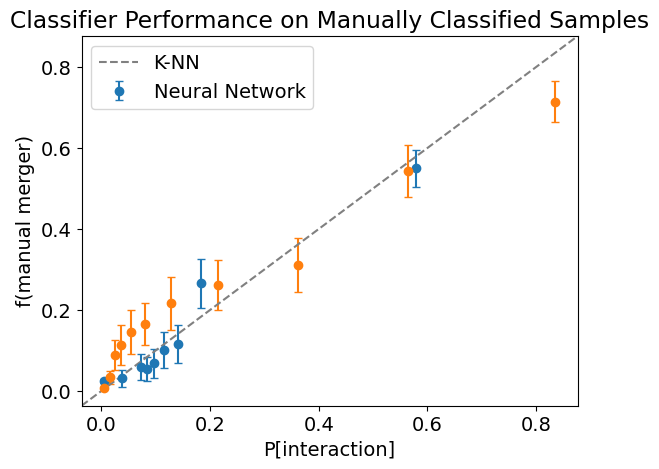

In [11]:
# Plot classifier performance on manually classified samples
manual_merger = np.in1d(labels, [2,3])
manual_nonmerger = labels==1

for samp in [pknn, pnn]:
    assns, bins = sampling.bin_by_count(pmerger(samp), 800, dx_min=0.01)
    
    ftp = sampling.classfraction(
        pmerger(samp)[manual_merger],
        pmerger(samp)[manual_nonmerger],
        add=True,
        alpha=0.16,
        bins=bins,
    )
    
    ek.errorbar(
        sampling.midpts(ftp[0]),
        np.mean(ftp[2], axis=0),
        ylow=ftp[2][0],
        yhigh=ftp[2][1],
        capsize=3
    )
    
ek.oneone()
plt.xlabel("P[interaction]")
plt.ylabel('f(manual merger)')
plt.title('Classifier Performance on Manually Classified Samples')
plt.legend(['K-NN', 'Neural Network'])
plt.show()

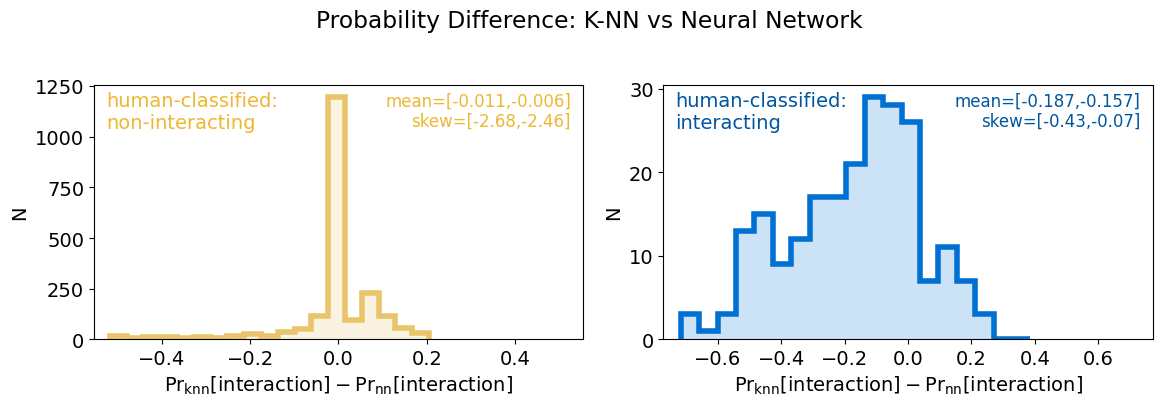

In [12]:
# Plot probability difference distributions for manually classified samples
fig, axarr = plt.subplots(1,2,figsize=(12,4))
hkwargs = {'lw':4,'alpha':0.2, 'bins':20}
ek.hist(dp[np.in1d(labels,[1])], ax=axarr[0], color=colorlists.slides['yellow'], **hkwargs)
ek.hist(dp[np.in1d(labels,[2,3])], ax=axarr[1], color=colorlists.slides['blue'], **hkwargs)

cc = [colorlists.slides['yellow'],colorlists.slides['blue']]
prefixes = ['non-','']  
lgroups = [[1],[2,3]]

for idx,ax in enumerate(axarr):
    ax.set_xlim(np.max(np.abs(ax.get_xlim()))*np.array([-1,1]))
    ax.set_ylabel("N")
    ax.set_xlabel(r'$\rm Pr_{knn}[interaction]-Pr_{nn}[interaction]$')

    mx = sampling.bootstrap_metric( sampling.fmasker(dp[np.in1d(labels,lgroups[idx])]), np.mean )
    sx = sampling.bootstrap_metric( sampling.fmasker(dp[np.in1d(labels,lgroups[idx])]), stats.skew )    
    ek.text(
        0.025, 
        0.975,
        f'''human-classified:
{prefixes[idx]}interacting''',
        ax=ax,
        color=ec.ColorBase(cc[idx]).modulate(-0.1,0.1).base
    )
    ek.text(    
        0.975,
        0.975,
        f'''mean=[{mx[0]:.3f},{mx[1]:.3f}]
skew=[{sx[0]:.2f},{sx[1]:.2f}]''',
        ax=ax,
        color=ec.ColorBase(cc[idx]).modulate(-0.1,0.1).base,
        fontsize=12
    )

plt.suptitle('Probability Difference: K-NN vs Neural Network', y=1.02)
plt.tight_layout()
plt.show()

## Visual Inspection of Disagreement Cases

In [13]:
# Identify cases where classifiers disagree
thresh = 0.6
dpthresh = 0.3

pos1 = (pmerger(pknn)>thresh)
negpos = (pmerger(pnn)>thresh)&(dp<-dpthresh)&(pnn[:,4]<frag_threshold)
posneg = (pmerger(pknn)>thresh)&(dp>dpthresh)&(pknn[:,4]<frag_threshold)
pos2 = (pmerger(pnn)>thresh)

groups = [pos1, negpos, posneg, pos2]
names = ['KNN+', 'KNN-/NN+', 'KNN+/NN-', 'NN+']
long_names = [
    'K-NN Positive',
    r'$\rm Pr_{knn}[int]<Pr_{nn}[int]$',
    r'$\rm Pr_{knn}[int]>Pr_{nn}[int]$',
    'Neural Network Positive'
]

for _ in range(len(groups)):
    print(f'{names[_]}: {groups[_].sum()}')

KNN+: 196
KNN-/NN+: 602
KNN+/NN-: 3
NN+: 1327


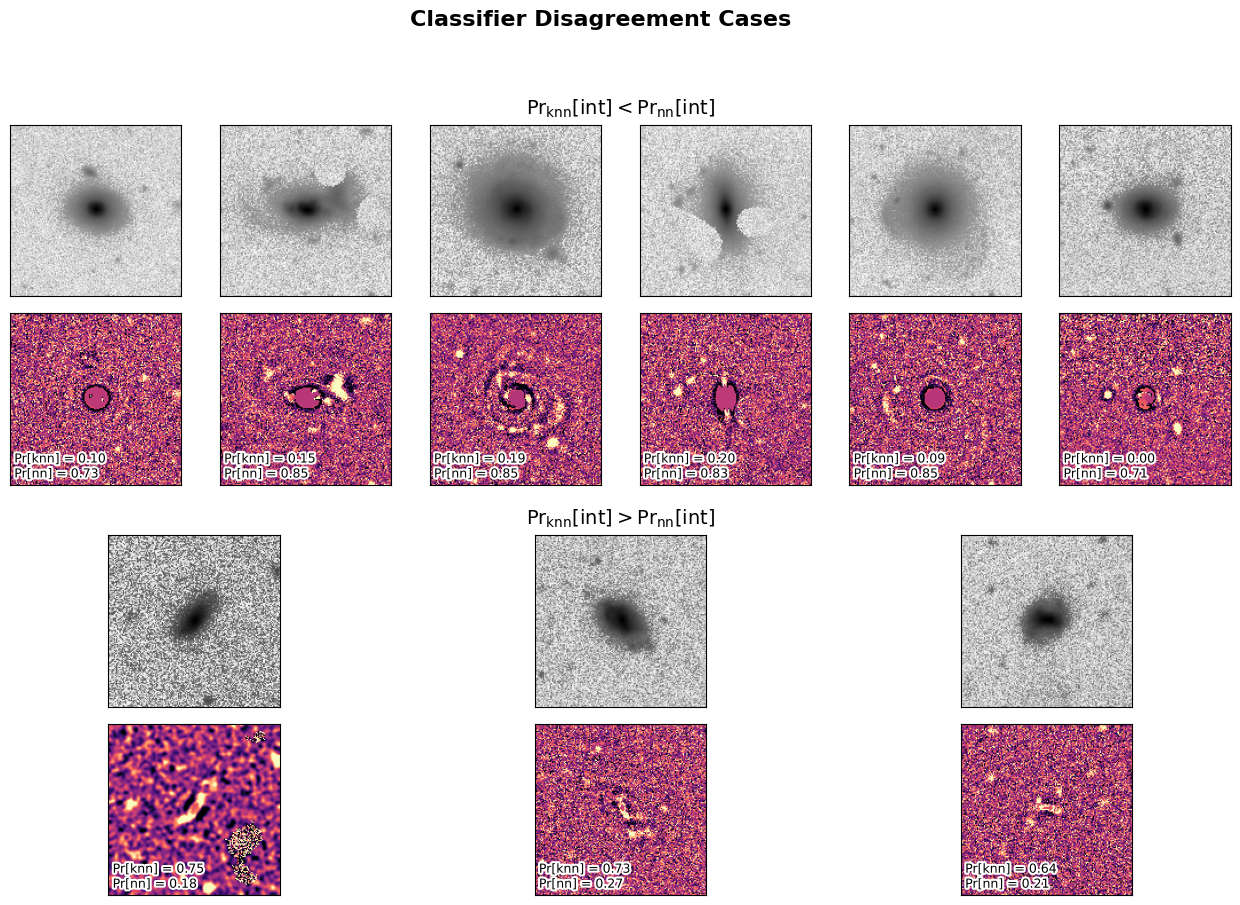

In [14]:
# Create visual comparison of disagreement cases
fig = plt.figure(figsize=(16, 10))

# Create a 2x1 GridSpec for two groups (showing only disagreement groups)
outer_grid = gridspec.GridSpec(2, 1, figure=fig, hspace=0.14)

# Define which groups to display (disagreement cases: groups 1 & 2)
groups_to_display = [1,2]

# Loop through each of the 2 groups
for idx, group_idx in enumerate(groups_to_display):
    # Get the mask for this group and filter image names
    group_mask = groups[group_idx]
    group_images = img_names[group_mask]
    
    num_examples = min(6, len(group_images))
    inner_grid = gridspec.GridSpecFromSubplotSpec(
        2, num_examples,
        subplot_spec=outer_grid[idx],
        hspace=0.1,
        wspace=0.1
    )
    
    # Randomly select examples from this group
    choices = np.random.choice(group_images, num_examples, replace=False)
    
    # Display each selected example in the grid
    for col in range(num_examples):
        # Load the image data for this example
        img = load_image_by_name(choices[col], data_path)
        
        # Display two versions of the image (grayscale and colored)
        for row in range(2):
            ax = fig.add_subplot(inner_grid[row, col])
            
            if row == 0:
                # Top row: Display grayscale image
                ax.imshow(
                    img[row + 1],
                    origin='lower',
                    cmap='Greys',
                    norm=colors.SymLogNorm(linthresh=0.1)
                )
            else:
                # Bottom row: Display HF image
                ek.imshow(img[row + 1], ax=ax, cmap='magma')
                
                # Add probability text overlay
                img_index = np.where(img_names == choices[col])[0][0]
                ek.text(
                    0.025,
                    0.025,
                    rf'''Pr[knn] = {pmerger(pknn)[img_index]:.2f}
Pr[nn] = {pmerger(pnn)[img_index]:.2f}''',
                    ax=ax,
                    fontsize=9,
                    bordercolor='w',
                    color='k',
                    borderwidth=3
                )
            
            # Remove axis ticks
            ax.set_xticks([])
            ax.set_yticks([])
    
    # Add title above this group's panel
    bbox = outer_grid[idx].get_position(fig)
    fig.text(
        bbox.x0 + bbox.width / 2,
        bbox.y1 + 0.005,
        f'{long_names[group_idx]}',
        ha='center',
        va='bottom',
        fontsize=14,
        fontweight='bold'
    )

plt.suptitle('Classifier Disagreement Cases', y=0.995, fontsize=16, fontweight='bold')
plt.show()

## Detailed Inspection: Cases Where Classifiers Disagree Strongly

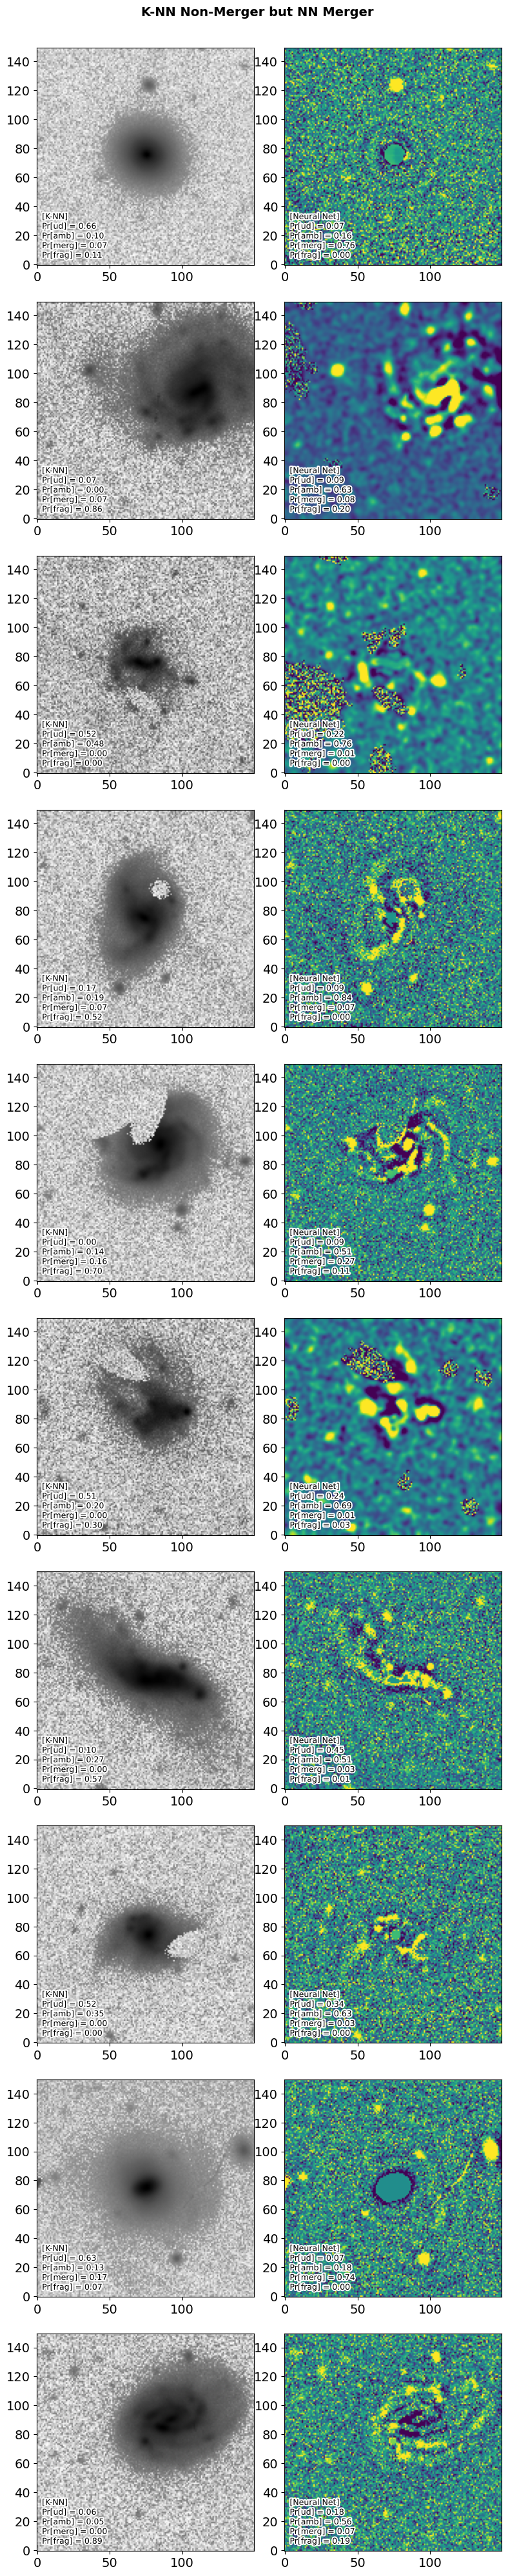

In [15]:
# Find cases where K-NN says non-merger but NN says merger
candidates = ~data['knn']['is_possible_merger'] & data['nn']['is_possible_merger']
n_candidates = min(10, candidates.sum())

fig, axarr = plt.subplots(n_candidates, 2, figsize=(8, 4*n_candidates))
if n_candidates == 1:
    axarr = axarr.reshape(1, -1)

for adx, idx in enumerate(np.random.choice(np.arange(len(img_names))[candidates], replace=False, size=n_candidates)):
    img = load_image_by_name(img_names[idx], data_path)
    
    axarr[adx, 0].imshow(
        img[1],
        origin='lower',
        cmap='Greys',
        norm=colors.SymLogNorm(linthresh=0.1)
    )
    ek.imshow(img[2], ax=axarr[adx,1])

    # Add statistics for K-NN classifier
    ek.text(
        0.025, 0.025,
        f"""[K-NN]
Pr[ud] = {pknn[idx, 1]:.2f}
Pr[amb] = {pknn[idx, 2]:.2f}
Pr[merg] = {pknn[idx, 3]:.2f}
Pr[frag] = {pknn[idx, 4]:.2f}""",
        ax=axarr[adx,0],
        fontsize=9,
        bordercolor='w',
        color='k',
        borderwidth=3
    )
    
    # Add statistics for NN classifier
    ek.text(
        0.025, 0.025,
        f"""[Neural Net]
Pr[ud] = {pnn[idx, 1]:.2f}
Pr[amb] = {pnn[idx, 2]:.2f}
Pr[merg] = {pnn[idx, 3]:.2f}
Pr[frag] = {pnn[idx, 4]:.2f}""",
        ax=axarr[adx,1],
        fontsize=9,
        bordercolor='w',
        color='k',
        borderwidth=3
    )

plt.suptitle('K-NN Non-Merger but NN Merger', y=1.00, fontsize=14, fontweight='bold')
plt.tight_layout()
plt.show()

## Probability Distribution Comparison

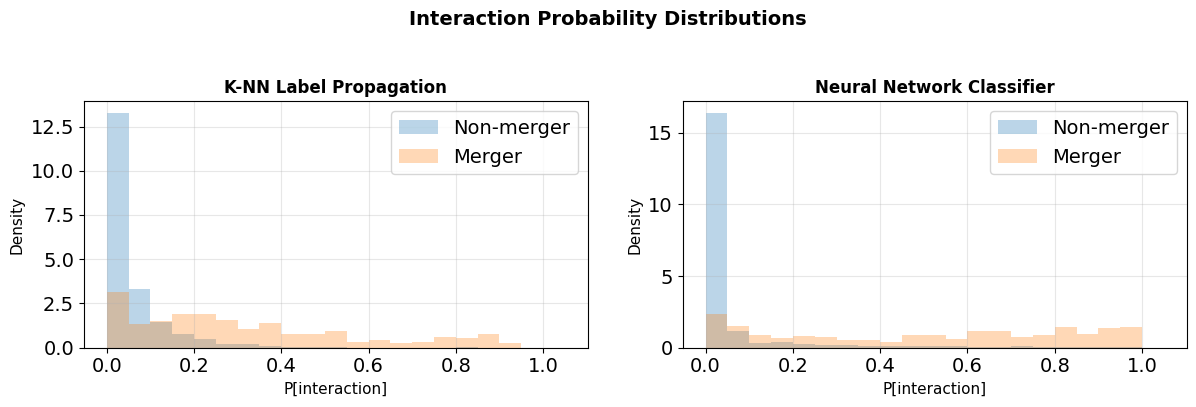

In [16]:
# Plot probability distributions for manually classified samples
manual_merger = (labels==2)|(labels==3)
manual_nonmerger = (labels==1)

hkwargs = {'alpha': 0.3, 'lw': 3, 'bins': np.arange(0., 1.1, 0.05), 'density': True}

fig, axarr = plt.subplots(1, 2, figsize=(12, 4))

# K-NN distributions
axarr[0].hist(pmerger(pknn)[manual_nonmerger], label='Non-merger', **hkwargs)
axarr[0].hist(pmerger(pknn)[manual_merger], label='Merger', **hkwargs)
axarr[0].set_xlabel('P[interaction]', fontsize=11)
axarr[0].set_ylabel('Density', fontsize=11)
axarr[0].set_title('K-NN Label Propagation', fontsize=12, fontweight='bold')
axarr[0].legend()
axarr[0].grid(alpha=0.3)

# Neural Network distributions
axarr[1].hist(pmerger(pnn)[manual_nonmerger], label='Non-merger', **hkwargs)
axarr[1].hist(pmerger(pnn)[manual_merger], label='Merger', **hkwargs)
axarr[1].set_xlabel('P[interaction]', fontsize=11)
axarr[1].set_ylabel('Density', fontsize=11)
axarr[1].set_title('Neural Network Classifier', fontsize=12, fontweight='bold')
axarr[1].legend()
axarr[1].grid(alpha=0.3)

plt.suptitle('Interaction Probability Distributions', y=1.02, fontsize=14, fontweight='bold')
plt.tight_layout()
plt.show()

## Summary Statistics

In [17]:
# Print summary statistics
print("\n" + "="*80)
print("CLASSIFIER COMPARISON SUMMARY")
print("="*80)

for name in data.keys():
    print(f"\n{classifiers[name]['label']}:")
    print(f"   Total galaxies: {len(data[name]['img_names'])}")
    print(f"   Merger candidates: {data[name]['is_possible_merger'].sum()}")
    print(f"   Mean interaction probability: {np.nanmean(pmerger(data[name]['prob_labels_iter'])):.4f}")

print("\n" + "="*80)
print(f"Configuration: {main_config['data']['output_path']}")
print(f"Fragmentation threshold: {frag_threshold}")
print("="*80)


CLASSIFIER COMPARISON SUMMARY

K-NN Label Propagation:
   Total galaxies: 22913
   Merger candidates: 400
   Mean interaction probability: 0.0624

Neural Network Classifier:
   Total galaxies: 22913
   Merger candidates: 1729
   Mean interaction probability: 0.0943

Configuration: ../output/sfourl_00
Fragmentation threshold: 0.25
